# Rate of Return for different weights (Market Cap vs Random vs Mean Variance vs LSTM)

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from tabulate import tabulate
import math
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

# yahoo_finance is used to fetch data 
import yfinance as yf

In [63]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

one_yr_ago = datetime.now() - relativedelta(years=1)
one_yr_ago = one_yr_ago.strftime("%Y-%m-%d")

start = one_yr_ago 
end = datetime.now().strftime("%Y-%m-%d")
symbols = ['FDS','INVH', 'ROL', 'RBLX', 'HIG']

In [64]:
all_df = yf.download(symbols, start, end)['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [65]:
df = all_df[['FDS','INVH', 'ROL', 'RBLX', 'HIG']]

In [66]:
df = df.reset_index() 

In [67]:
df

,Date,FDS,INVH,ROL,RBLX,HIG
0,2022-07-25,402.740021,35.434799,36.035286,39.840000,63.300156
1,2022-07-26,401.758484,35.580585,35.768650,39.000000,62.880043
2,2022-07-27,405.297852,35.930462,34.919369,41.950001,62.860493
3,2022-07-28,417.531799,37.534069,38.089367,42.980000,61.404762
4,2022-07-29,425.988525,37.932533,38.089367,42.930000,62.987514
...,...,...,...,...,...,...
245,2023-07-17,420.100006,35.330002,44.590000,44.459999,72.220001
246,2023-07-18,424.359985,34.830002,44.480000,45.540001,72.639999
247,2023-07-19,425.179993,35.299999,44.360001,44.860001,72.430000
248,2023-07-20,429.600006,35.669998,44.369999,41.040001,74.639999


# Weekly returns (I assumed rolling average)

In [68]:
weekly_returns = df[['FDS','INVH', 'ROL', 'RBLX', 'HIG']].pct_change(periods=5) # go by business days 

In [69]:
weekly_returns =weekly_returns.dropna()

In [70]:
weekly_returns

,FDS,INVH,ROL,RBLX,HIG
5,0.040790,0.056226,0.071526,0.135542,-0.020991
6,0.038693,0.037421,0.063777,0.161282,-0.021753
7,0.033414,0.018934,0.082013,0.120381,-0.013833
8,0.008619,-0.018126,-0.021519,0.115868,0.004455
9,-0.014825,-0.029464,-0.025149,0.146983,-0.004808
...,...,...,...,...,...
245,0.062388,0.016691,0.030268,0.067980,-0.003862
246,0.059047,-0.011915,0.017849,0.043538,-0.006972
247,0.064227,0.000000,0.010018,0.032214,-0.002342
248,0.038082,0.004789,0.007722,-0.073589,0.029659


In [71]:
weekly_returns['FDS'].mean()

0.0014607365152132835

In [72]:
weekly_returns['INVH'].mean()

7.357829650857754e-05

In [73]:
weekly_returns['ROL'].mean()

0.00460953721900936

# Efficient Portfolio (completly random)

In [74]:
import numpy as np, numpy.random

In [75]:
np.random.seed(1885451)

In [76]:

num_assets =  len(symbols)
weights = np.random.dirichlet(np.ones(num_assets),size=1)[0]
# next : weights = np.array(num_assets * [1. / num_assets,])

print("random weights: ", weights)


random weights:  [0.01280302 0.48843802 0.04385469 0.02000437 0.43489989]


In [77]:
opt_weights = [float(i) for i in weights]
#opt_weights

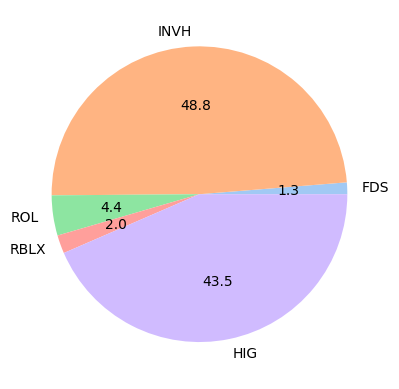

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

#define data
data = opt_weights
labels = symbols

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.1f')
plt.show()

In [79]:
tot_return = sum(df[['FDS', 'INVH', 'ROL', 'RBLX', 'HIG']].iloc[-1].values* opt_weights) 
tot_return -= sum(df[['FDS', 'INVH', 'ROL', 'RBLX', 'HIG']].iloc[0].values* opt_weights)
tot_return

5.827939026220477

In [80]:
random_returns = tot_return

# Efficient Portfolio (Market-Cap)

In [81]:
df_market_cap = pd.DataFrame()


In [82]:
mcstock = []
for stock in symbols: 
    info = yf.Ticker(stock).fast_info
    marketcap = info['market_cap']
    mcstock.append(marketcap) 
df_market_cap['Stock'] = symbols
df_market_cap['Marketcap'] = mcstock

In [83]:
df_market_cap

,Stock,Marketcap
0,FDS,1.655172e+10
1,INVH,2.220648e+10
2,ROL,2.193888e+10
3,RBLX,2.477533e+10
4,HIG,2.300703e+10


In [84]:
opt_weights = [i/sum(mcstock) for i in mcstock]

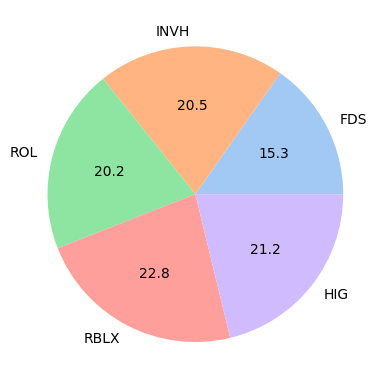

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

#define data
data = opt_weights
labels = symbols

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.1f')
plt.show()

In [86]:
tot_return = sum(df[['FDS', 'INVH', 'ROL', 'RBLX', 'HIG']].iloc[-1].values* opt_weights) 
tot_return -= sum(df[['FDS', 'INVH', 'ROL', 'RBLX', 'HIG']].iloc[0].values* opt_weights)
tot_return

8.785572951664761

In [87]:
marketcap_returns= tot_return

# Efficient Portfolio (Mean-Variance) 

In [20]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize




def portfolio_risk(W, returns):
    portfolio_return = np.sum(returns.mean() * W) 
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), W)))
    return portfolio_std_dev


num_assets =  len(symbols)
# for fun: weights = np.random.dirichlet(np.ones(num_assets),size=1)[0]
weights = np.array(num_assets * [1. / num_assets,])

print("weights: ", weights)
bounds = tuple((0, 1) for asset in range(num_assets))

constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]

minimized_risk = minimize(portfolio_risk, weights, args=(df[['FDS', 'INVH', 'ROL', 'RBLX', 'HIG']].pct_change()), method='SLSQP', bounds=bounds, constraints=constraints)

print(minimized_risk.x)

weights:  [0.2 0.2 0.2 0.2 0.2]
[5.90499871e-15 3.64183510e-15 4.78547894e-01 6.26668856e-16
 5.21452106e-01]


In [21]:
opt_weights = [float(i) for i in minimized_risk.x]

In [22]:
tot_return = sum(df[['FDS', 'INVH', 'ROL', 'RBLX', 'HIG']].iloc[-1].values* opt_weights) - sum(df[['FDS', 'INVH', 'ROL', 'RBLX', 'HIG']].iloc[0].values* opt_weights)

In [23]:
tot_return

9.723232880394917

In [24]:
mv_return = tot_return

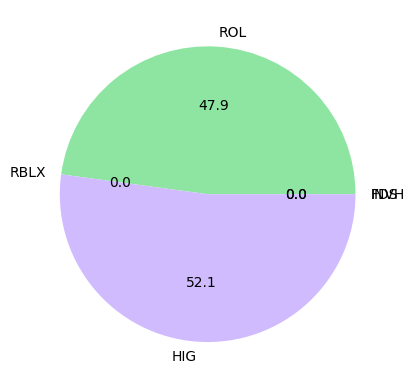

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

#define data
data = opt_weights
labels = symbols

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.1f')
plt.show()

# Efficient Portfolio (LSTM)

In [26]:
import numpy as np
import tensorflow as tf
import json
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import f_regression
import datetime as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
def run_sk_lstm_model(normalized_df, prediction_days=25, num_epochs=30, num_batch_size=5):
    """
    Run the SK-LSTM model on the provided normalized DataFrame.

    Args:
        normalized_df (pandas.DataFrame): The normalized DataFrame.
        prediction_days (int): The number of previous days to use for prediction. Default is 20.
        num_epochs (int): The number of training epochs. Default is 3.
        num_batch_size (int): The batch size for training. Default is 32.

    Returns:
        tuple: A tuple containing the trained model and the predicted values.

    """
    print("prediction_days: ", prediction_days)

    # Split the data into input (x) and output (y) variables
    x_train, y_train = split_x_data(normalized_df) 
    print("x_train, y_train", x_train.shape, y_train.shape)

    # Convert the data to float32 type
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')

    # Get the list of columns to use as input features
    vals_to_use = normalized_df.columns.to_list()
    fv = len(vals_to_use)

    # Define the SK-LSTM model
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(prediction_days, fv)))
    model.add(tf.keras.layers.LSTM(units=prediction_days))
    # if model is over-fitting: model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(fv * prediction_days, activation='linear'))
    model.add(tf.keras.layers.Dense(prediction_days, activation="relu"))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=['mse'])

    # Train the model
    model.fit(x=x_train, y=y_train,
              batch_size=num_batch_size, epochs=num_epochs)

    # Predict the output values
    y_pred = model.predict(x_train)

    return model, y_pred

def get_transform(df):
    """
    Apply a transformation to a variable using the maximum and minimum values of a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame used to calculate the maximum and minimum values.

    Returns:
        The transformed variable.

    """
    return (df-df.min())/(df.max()-df.min())

def remove_outliers(df):
    """
    Remove outliers from the DataFrame based on a specified target variable.

    Args:
        df (pandas.DataFrame): The DataFrame to remove outliers from.

    Returns:
        pandas.DataFrame: The DataFrame with outliers removed.

    """
    X = df.values
    cols = [i for i in df.columns]
    # identify outliers in the training dataset
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X)
    # select all rows that are not outliers
    mask = yhat != -1
    outliers_removed = df
    outliers_removed["eff_mask"] = mask
    outliers_removed = outliers_removed[outliers_removed["eff_mask"] == True]
    df = outliers_removed
    return df[cols]

2023-07-23 17:47:53.535997: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
def split_x_data(normalized_df, var = "predict",prediction_days=25,fv=5):
    """
    Split the data into input (x) and output (y) variables for training an LSTM model.

    Args:
        normalized_df (pandas.DataFrame): The normalized DataFrame.
        prediction_days (int): The number of previous days to use for prediction. Default is 20.
        final_x (bool): Whether to return only the final x_train. Default is False.

    Returns:
        tuple: A tuple containing the input (x_train) and output (y_train) variables.

    """
    #scaled_data = normalized_df.copy(deep=False).values.reshape(-1, fv)
    normalized_df["predict"] = np.max(normalized_df.shift(-1),axis=1) 
        # really dumb monte-carlo-like strategy to invest in one stock each day and predict next value
        
    vals_to_use = normalized_df.columns.to_list()
    fv = len(vals_to_use)
    scaled_data = normalized_df.copy(deep=False).values.reshape(-1, fv)
    
    x_train = []
    y_train = []
    

    var_index = vals_to_use.index(var)

    for x in range(prediction_days, len(scaled_data)-prediction_days):
        x_train.append(scaled_data[x-prediction_days:x, :])
        y_train.append(scaled_data[x:x+prediction_days, var_index])

    x_train, y_train = np.array(x_train), np.array(y_train)
    print("x_train, y_train", x_train.shape, y_train.shape)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], fv))
    return x_train, y_train


In [28]:
idx_normalized_df = df[['FDS', 'INVH', 'ROL', 'RBLX', 'HIG']].copy(deep=False)
out_df = remove_outliers(idx_normalized_df)
normalized_df = get_transform(out_df)


In [92]:
model, y_pred = run_sk_lstm_model(normalized_df,num_epochs=20)

prediction_days:  25
x_train, y_train (199, 25, 6) (199, 25)
x_train, y_train (199, 25, 6) (199, 25)
Epoch 1/20
40/40 [==============================] - 2s 5ms/step - loss: 0.2688 - mse: 0.2688
Epoch 2/20
40/40 [==============================] - 0s 6ms/step - loss: 0.0818 - mse: 0.0818
Epoch 3/20
40/40 [==============================] - 0s 5ms/step - loss: 0.0732 - mse: 0.0732
Epoch 4/20
40/40 [==============================] - 0s 5ms/step - loss: 0.0700 - mse: 0.0700
Epoch 5/20
40/40 [==============================] - 0s 5ms/step - loss: 0.0680 - mse: 0.0680
Epoch 6/20
40/40 [==============================] - 0s 5ms/step - loss: 0.0672 - mse: 0.0672
Epoch 7/20
40/40 [==============================] - 0s 5ms/step - loss: 0.0668 - mse: 0.0668
Epoch 8/20
40/40 [==============================] - 0s 5ms/step - loss: 0.0661 - mse: 0.0661
Epoch 9/20
40/40 [==============================] - 0s 5ms/step - loss: 0.0661 - mse: 0.0661
Epoch 10/20
40/40 [==============================] - 0s 6ms/st

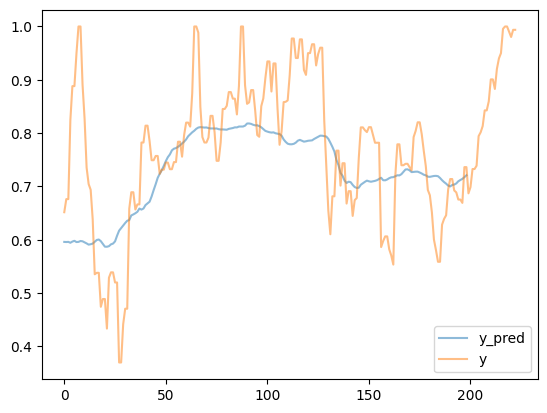

In [93]:
import matplotlib.pyplot as plt
plt.plot(np.mean(y_pred,axis=1),label='y_pred',alpha=0.5)
plt.plot(normalized_df['predict'].values[25:],label='y',alpha=0.5)
plt.legend()

In [94]:
#get last layer output 
biases = model.layers[-1].get_weights()[-1].reshape(5,5)
values = np.mean(biases, axis=0)


In [95]:
values /= np.sum(values)

In [96]:
opt_weights = values

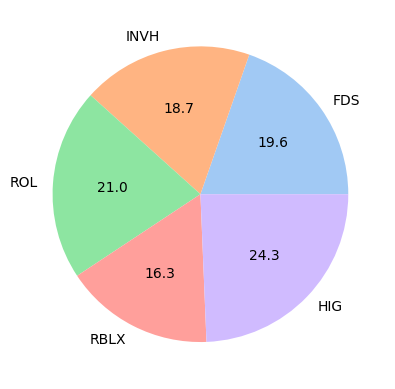

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

#define data
data = opt_weights
labels = symbols

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.1f')
plt.show()

## YAY!!!: improved performance with LSTM predicted importance 

In [98]:
tot_return = sum(df[['FDS', 'INVH', 'ROL', 'RBLX', 'HIG']].iloc[-1].values* opt_weights) 
tot_return -= sum(df[['FDS', 'INVH', 'ROL', 'RBLX', 'HIG']].iloc[0].values* opt_weights)
tot_return

10.409730758459546

In [99]:
lstm_return = tot_return

# RESULTS

In [100]:
result_df = pd.DataFrame()
result_df["lstm"] = [lstm_return]
result_df["mean-var"] = [mv_return]
result_df["random"] = [random_returns]
result_df["marketcap"] = [marketcap_returns]
result_df.index.name = "returns"
result_df

,lstm,mean-var,random,marketcap
returns,,,,
0,10.409731,9.723233,5.827939,8.785573


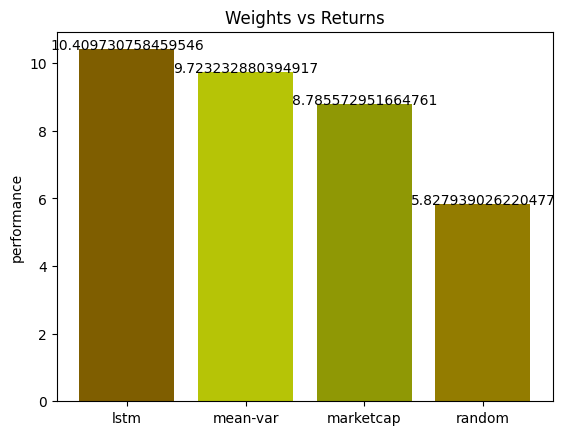

In [101]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

algs = ["lstm", "mean-var","marketcap","random"]
counts = [lstm_return,mv_return,marketcap_returns,random_returns]
bar_labels = ['xkcd:poop','xkcd:baby puke green', 'xkcd:baby poop green','xkcd:baby poop']
bar_colors = bar_labels

ax.bar(algs, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('performance')
ax.set_title('Weights vs Returns')
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
addlabels(algs, counts)
plt.show()